# Kaggle: San Francisco Crime Classification

In this excercise we will create an improved version of last years model.

Please be aware that the following packages and additional assets have to be installed in the conda environment to guarantue proper execution of this notebook
- gmaps
- osmnx

In [1]:
# imports
import math
import datetime
import matplotlib
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
import numpy as np
import pprint
import requests
import gmaps
import seaborn as sns
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier

## Data exploration

First we load and explore the dataset a little.

In [2]:
train_data = pd.read_csv("../../data/raw/train.csv")
train_data['Dates'] = pd.to_datetime(train_data['Dates'])

test_data = pd.read_csv("../../data/raw/test.csv")
test_data['Dates'] = pd.to_datetime(test_data['Dates'])

In [3]:
print("Size of train_data: ", len(train_data))
print("Size of test_data: ", len(test_data))

Size of train_data:  878049
Size of test_data:  884262


In [4]:
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


There are strong differences in the frequencies in which the different categories of crime occur. Larency/Theft make up most of the commited crimes, whereas other, possibly minor offenses are the second most 

In [5]:
# visualizing category distribution of the crimes
#crimes = train_data['Category'].unique()
#print("Categories:", crimes)
#train_data['Category'].value_counts(sort=False).plot.bar()
#plt.show()

Next we take a look at the concentration of criminal activity for 2010-2015 which gives us a hint that crimes are most concentrated around the union square

In [6]:
# load private google api key
file = open("./assets/gapi.key", 'r')
key = file.read()
file.close()
gmaps.configure(api_key=key)

In [7]:
# Creating a location subset from the most current crimes (2010-2015) for heatmap visualization
import datetime
start_date = datetime.date(2010,1,1)
end_date = datetime.date(2016,1,1)
date_mask = (train_data['Dates'] > start_date) & (train_data['Dates'] <= end_date)
location_subset = train_data.loc[date_mask][['Y', 'X']]
locations = [tuple(x) for x in location_subset.values]
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations))
fig

Next we look up the locations for different crime categories to examine if there are category patterns available in the underlying data

In [8]:
# Manual Inspection of specific incidents to check if different crime types are locally bounded
def draw_category_gmap(category, start_date, end_date):
    specific_incidents = train_data.loc[train_data['Category']==category]
    date_mask = (specific_incidents['Dates'] > start_date) & (specific_incidents['Dates'] <= end_date)
    location_subset = specific_incidents.loc[date_mask][['Y', 'X']]
    locations = [tuple(x) for x in location_subset.values]
    spec_fig = gmaps.figure()
    gmaps.heatmap_layer.max_intensity = 1000
    gmaps.heatmap_layer.point_radius = 2
    spec_fig.add_layer(gmaps.heatmap_layer(locations))
    return spec_fig

In [9]:
draw_category_gmap('KIDNAPPING', datetime.date(2010,1,1), datetime.date(2016,1,1))

In [10]:
draw_category_gmap('WARRANTS', datetime.date(2010,1,1), datetime.date(2016,1,1))   

In [11]:
draw_category_gmap('DRUNKENNESS', datetime.date(2010,1,1), datetime.date(2016,1,1))

Most crimes are distributed arround the union square and in lesser density distributed over san francisco whereas PROSTITUTION is well contained in two areas

## Feature extraction

In the following we present our different features which we combine for a data preparation method.

### Time based features
First we have some time based features because we assume a correlation between the categorie of crime and time when it is committed.

In [12]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# some functions for time based features
first_sixth = datetime.time(23,59,59)
second_sixth = datetime.time(3,59,59)
third_sixth = datetime.time(7,59,59)
fourth_sixth = datetime.time(11,59,59)
fifth_sixth = datetime.time(15,59,59)
sixth_sixth = datetime.time(19,59,59)

cal = calendar()
holiday_timetamps = cal.holidays(start='2003-01-01', end='2015-05-13')
holidays = []
for t in holiday_timetamps:
    holidays.append(t.date())
holidays = set(holidays)

def get_halfhour(minute):
    if minute < 30:
        return 0
    else:
        return 1

def get_daynight(hour):
    if 5 < hour and hour < 23:
        return 0
    else:
        return 1

def generate_day_sixths(times):
    """This function has to be executed on the original datetime features"""

    def day_sixths(dt):
        """
        Mapping time to sixths of a day
        """
        if dt.time() > datetime.time(0,0,0) and dt.time() <= second_sixth:
            return 0/6
        if dt.time() > second_sixth and dt.time() <= third_sixth:
            return 1/6
        if dt.time() > third_sixth and dt.time() <= fourth_sixth:
            return 2/6
        if dt.time() > fourth_sixth and dt.time() <= fifth_sixth:
            return 3/6
        if dt.time() > fifth_sixth and dt.time() <= sixth_sixth:
            return 4/6
        if dt.time() > sixth_sixth and dt.time() <= first_sixth:
            return 5/6
        
    return times.map(day_sixths)

def get_holiday(day, date):
    if day == "Sunday" or date in holidays:
        return 1
    else:
        return 0
    
def generate_time_features(data):
    times = data["Dates"]    
    days = data["DayOfWeek"]
    #perhaps try one hot encoding for some of the series.    
    minute_series = pd.Series([x.minute for x in times], name='minute')
    # halfhour_series = pd.Series([get_halfhour(x.minute) for x in times], name='halfhour')
    # hour_series = pd.Series([x.hour for x in times], name='hour')
    daynight_series = pd.Series([get_daynight(x.hour) for x in times], name='day_night')
    day_series = pd.Series([x.day for x in times], name='day')
    month_series = pd.Series([x.month for x in times], name='month')
    year_series = pd.Series([x.year for x in times], name='year')
    # sixths = pd.Series(generate_day_sixths(times), name='day_sixths')
    day_of_week = pd.get_dummies(days)
    is_holiday = pd.Series([get_holiday(days[i], times[i].date()) for i in range(len(times))], name='is_holiday')
    minute_one_hot = pd.get_dummies(minute_series)
    # better than phase and hour if no one hot encoding is used
    rel_time = pd.Series([(x.hour + x.minute / 60) for x in times], name='rel_time')
    
    time_features = pd.concat([minute_one_hot, rel_time, day_of_week, is_holiday, daynight_series,
                               day_series, month_series, year_series], axis=1)
    return time_features

In [13]:
# show the structure of our time based features]
#time_features = generate_time_features(data)
#time_features['sixths'] = generate_day_sixths(times)
#time_features.head()

### Assign crimes to cells in a grid

Like in the presentation we create a grid which covers San Francisco and calculate the distribution of the different crime categories for each cell. You can see in the heatmap above, that there are certain hot spots for different categories of crimes.

In [14]:
# We define a bounding box arround San Francisco
min_x = -122.53
max_x = -122.35
min_y = 37.65
max_y = 37.84

dif_x = max_x - min_x
dif_y = max_y - min_y

We noticed that there a 67 crimes in the training set which were committed outside San Francisco. We notice that these outliers were all committed at the same position (X=-120.5, Y=90), which is right at the geographic North Pole. To deal with them we map all of them in an empty subregion into the sea in the north western corner of San Francisco. 

In [15]:
# Please zoom out a little bit to identify the location of this point , 
marker_loc = [(37.783939,-122.412614)]
spec_fig = gmaps.figure()
spec_fig.add_layer(gmaps.marker_layer(marker_loc))
spec_fig

AssertionError: 

In [15]:
# Functions to reposition outliers into a separate valid region.
def reposition_x(x):
    if x < min_x or max_x <= x:
        return -122.412614
    else: 
        return x

def reposition_y(y):
    if y < min_y or max_y <= y:
        return 37.783939
    else:
        return y

def reposition_outliers(data):
    repositioning = data.copy()
    new_X = pd.Series([reposition_x(x) for x in data["X"]], name='X')
    repositioning = repositioning.drop('X', axis=1)
    new_Y = pd.Series([reposition_y(y) for y in data["Y"]], name="Y")
    repositioning = repositioning.drop('Y', axis=1)
    repositioning = pd.concat([repositioning, new_X, new_Y], axis=1)
    return repositioning

In [16]:
train_data = reposition_outliers(train_data)

Next we define functions to assign each crime according to its position to the right cell of the grid. 

In [17]:
# grid functions
def assign_subregion(pos_x, pos_y, min_x, min_y, dif_x, dif_y, x_sections, y_sections):
    x = pos_x - min_x
    x_sec = int(x_sections * x / dif_x)
    y = pos_y - min_y
    y_sec = int(y_sections * y / dif_y)
    return x_sec + x_sections * y_sec
    
def create_subregion_series(data, min_x, min_y, dif_x, dif_y, x_sections, y_sections):
    subregion_list = []
    for i in range(len(data)):
        pos_x = data["X"][i]
        pos_y = data["Y"][i]
        subregion = assign_subregion(pos_x, pos_y, min_x, min_y, dif_x, dif_y, x_sections, y_sections)
        subregion_list.append(subregion)
    return pd.Series(subregion_list, name='subregion')

def get_subregion_pos(subregion_id, min_x, min_y, dif_x, dif_y, x_sections, y_sections):
    x = subregion_id % x_sections
    x_pos = ((x + 1/2) / x_sections) * dif_x + min_x
    y = subregion_id // x_sections
    y_pos = ((y + 1/2) / y_sections) * dif_y + min_y
    return (x_pos, y_pos)

def get_subregion_rectangle(subregion_id, min_x, min_y, dif_x, dif_y, x_sections, y_sections):
    x = subregion_id % x_sections
    y = subregion_id // x_sections
    x_pos_ll = (x / x_sections) * dif_x + min_x
    y_pos_ll = (y  / y_sections) * dif_y + min_y
    lower_left = (x_pos_ll, y_pos_ll)
    x_pos_ur = ((x + 1) / x_sections) * dif_x + min_x
    y_pos_ur = ((y + 1)  / y_sections) * dif_y + min_y
    upper_right= (x_pos_ur, y_pos_ur)
    return lower_left, upper_right

In [18]:
# show the structure of subregion feature
#subregions = create_subregion_series(train_data, min_x, min_y, dif_x, dif_y, 20, 20)
#subregions_df = pd.concat([subregions], axis=1)
#subregions_df.head()

### Avoiding floating point errors

Because many probabilities in the following statistics are close to zero, we use logit to avoid floating point inaccuracies.

In [19]:
from math import log

def logit(p):        
    return log(p / (1 - p))

logit_eps = 0.0001 
upper_bound = 1 - logit_eps
logit_one = logit(1 - logit_eps)
logit_zero = logit(logit_eps)

def calc_logit(p):
    if p < logit_eps:
        return logit_zero
    elif p > upper_bound:
        return logit_one
    else:
        return logit(p)

### Non-prosecution rate per grid cell

Like in the presentation we calculate the non-prosecution rate for each cell in the grid. Areas with high non-prosecution rate may have lower police presence.

In [20]:
# functions to calculate the non-prosecution rate for each cell in the grid.

def count_non_prosecuted_crimes(data, subregions, num_regions):
    none_prosecutions_local = {}
    none_prosecutions_overall = data["Resolution"].value_counts()["NONE"]
    resolution = data["Resolution"]
    for r in range(num_regions):
        none_prosecutions_local[r] = 0
    for i, r in enumerate(subregions):
        if resolution[i] == "NONE":
            none_prosecutions_local[r] += 1
    return none_prosecutions_local, none_prosecutions_overall

def calculate_prosection_rates(counts_local, counts_overall, subregions, num_regions, sufficient_n):
    none_prosecutions_rate_overall = calc_logit(counts_overall / len(subregions))
    none_prosecution_rate_local = {}
    occupied_regions = subregions.unique()
    counts = subregions.value_counts()
    for r in range(num_regions):
        if r in occupied_regions and counts[r] >= sufficient_n:
            none_prosecution_rate_local[r] = calc_logit(counts_local[r] / counts[r])
        else: 
            none_prosecution_rate_local[r] = none_prosecutions_rate_overall
    return none_prosecution_rate_local
            
def get_non_prosecution_rate_frame(data, subregions, num_regions, sufficient_n):
    counts_local, counts_overall = count_non_prosecuted_crimes(data, subregions, num_regions)
    rates_local = calculate_prosection_rates(counts_local, counts_overall, subregions, num_regions, sufficient_n)        
    non_prosecution_series = pd.Series([rates_local[x] for x in range(num_regions)], name='non_prosecution_rate')
    return non_prosecution_series

In [21]:
# show the structure of non-prosecution rate feature
#non_prosecution_rate = get_non_prosecution_rate_frame(train_data, subregions, 400, 50)
#non_prosecution_rate.head()

### Crime category distribution per grid cell

Our next feature is the distrubition of crime categories in a grid cell. Certain ares might be hot spots for different types of crime and we want to define what is normal for a region.

In [22]:
# functions to calculate the category distribution rate for each cell in the grid.

def count_crimes_per_category(data, subregions, crimes, num_regions):
    # count crimes per region and category
    criminal_activity_local = {}
    criminal_activity_overall = data["Category"].value_counts()
    category = data["Category"]
    for r in range(num_regions):
        criminal_activity_local[r] = {}
        for c in crimes:
            criminal_activity_local[r][c] = 0
    for i, r in enumerate(subregions):
        criminal_activity_local[r][category[i]] += 1
    return criminal_activity_local, criminal_activity_overall

def determine_distribution_categories(data, activity_lokal, activity_overall, subregions, crimes, num_regions, sufficient_n):
    distribution_global = {}
    for c in crimes:
        distribution_global[c] = calc_logit(activity_overall[c] / len(data))
    occupied_regions = subregions.unique()
    counts = subregions.value_counts()
    distribution_local = {}
    for r in range(num_regions):
        distribution_local[r] = {}
        for c in crimes: 
            if r in occupied_regions and counts[r] >= sufficient_n:
                distribution_local[r][c] = calc_logit(activity_lokal[r][c] / counts[r])
            else:
                distribution_local[r][c] = distribution_global[c]
    return distribution_local

def get_crime_distribution_frame(data, subregions, crimes, num_regions, sufficient_n):
    activity_lokal, activity_overall = count_crimes_per_category(data, subregions, crimes, num_regions)
    distribution_local = determine_distribution_categories(data, activity_lokal, activity_overall, subregions, crimes, num_regions, sufficient_n)
    # convert to dataframe
    distribution_frame = pd.DataFrame()
    for c in crimes:
        category_series = pd.Series([distribution_local[r][c] for r in range(num_regions)], name=c)
        distribution_frame = pd.concat([distribution_frame, category_series], axis=1)
    return distribution_frame

In [23]:
# show the structure of category distribution feature
#distribution_frame = get_crime_distribution_frame(train_data, subregions, crimes, 400, 50)
#distribution_frame.head()

##  Streets crime category distribution

Our next feature is the distrubition of crime categories per street. Certain streets might be hot spots for different types of crime.

In [24]:
# functions for street statistics
def get_relevant_streets(data, sufficient_n):
    streets = data["Address"]
    street_counts = streets.value_counts()
    relevant_streets = []
    for k in street_counts.keys():
        if street_counts[k] >= sufficient_n:
            relevant_streets.append(k)
        else:
            break
    return relevant_streets

def count_street_crime_per_category(data, relevant_streets, crimes):
    # count crimes per region and category
    street_activity = {}
    streets = data["Address"]
    category = data["Category"]
    for s in relevant_streets:
        street_activity[s] = {}
        street_activity[s]["crime_count"] = 0
        for c in crimes:
            street_activity[s][c] = 0
    for i, s in enumerate(streets):
        if s in street_activity:
            street_activity[s][category[i]] += 1
            street_activity[s]["crime_count"] += 1
    return street_activity

def determine_street_crime_distribution_categories(data, relevant_streets, street_activity, crimes):
    # default distribution
    street_distribution = {}
    street_distribution["DEFAULT_DISTRIBUTION"] = {}
    overall_counts = data["Category"].value_counts()
    for c in crimes:
         street_distribution["DEFAULT_DISTRIBUTION"][c] = calc_logit(overall_counts[c] / len(data))
    # street distribution
    for s in relevant_streets:
        street_distribution[s] = {}
        for c in crimes: 
            street_distribution[s][c] = calc_logit(street_activity[s][c] / street_activity[s]["crime_count"])
    return street_distribution

def get_street_crime_distribution_dict(data, crimes, sufficient_n=48):
    rel_streets = get_relevant_streets(data, sufficient_n)
    street_activity = count_street_crime_per_category(data, rel_streets, crimes)
    street_distribution = determine_street_crime_distribution_categories(data, rel_streets, street_activity, crimes)
    # convert to dataframe
    '''
    street_distribution_frame = pd.DataFrame()
    for c in crimes:
        category_series = pd.Series([street_distribution[s][c] for s in rel_streets] + [street_distribution["DEFAULT_DISTRIBUTION"][c]],
                                    name=("street_" + c))
        street_distribution_frame = pd.concat([street_distribution_frame, category_series], axis=1)
    '''
    return street_distribution

def get_street_crime_rate(street, crime, street_crime_distribution):
    if street in street_crime_distribution.keys():
        return street_crime_distribution[street][crime]
    else:
        return street_crime_distribution['DEFAULT_DISTRIBUTION'][crime]

### One-hot encoding of police destricts
We assume dependencies between the police district in which a crime takes place and its category.

In [25]:
def create_police_destrict_frame(data):
    one_hot_police_destricts = pd.get_dummies(data["PdDistrict"])
    return one_hot_police_destricts

In [26]:
# show the structure of the police destrict feature
#police_destricts = create_police_destrict_frame(train_data)
#police_destricts.head()

### Distance to the next police station

Our next feature is the distance between the place where the crime is committed and the nearest police station, because police presence may influence the category of crime which is committed.

In [27]:
# function to measure distance to next police station
from geopy.distance import vincenty

police_stations = pd.read_json("https://data.sfgov.org/resource/me2e-mc38.json")

police_station_coordinates = []
for elem in police_stations.iterrows():
    """Create police station coordinates as tuple"""
    police_station_coordinates.append(tuple(elem[1]['location']['coordinates']))

def get_crime_coordinate_series(data):
    # prepare crime X,Y coordinates as tuple of coordinates
    return list(zip(data['X'], data['Y']))
    
def caculate_min_distance_police(crime_coordinate):
    """calculate distance from crime to nearest police station"""
    current_min = 10000000
    for police_station_coordinate in police_station_coordinates:
        current_min = min(current_min, vincenty(police_station_coordinate, crime_coordinate).meters)
    return current_min

def get_police_distance_series(data):
    get_crime_coordinates = get_crime_coordinate_series(data)
    police_distance_series = pd.Series([caculate_min_distance_police(c) for c in get_crime_coordinates], name='police_distance')
    return police_distance_series

In [28]:
# show the structure of the police distance feature
#police_dist_series = get_police_distance_series(train_data)
#police_dist_pd = pd.concat([police_dist_series], axis=1)
#police_dist_pd.head()

### Additional Spatial and other Features
After the commonly known grid features additionals metrics for the grids are calculated describing the area topology and architectural grid features

#### Street Types
If a mapping can be caclulated the corresponding street type is used. Always the first occuring street type will be used. If the crime address includes a "/" symbol this means a crossing like a corner to another street is meatn and the type CRO (Crossing) is inferred, else the most common type RD for Road is used. This represents basically a simple street taxonomy. A one-hot encoded dataset is returned.

In [29]:
types = ['ST','AV','BL', 'BL NORTH', 'BL SOUTH',  'AVE','AL', 'ALY', 'CT', 'WY' ,'WAY', 'TER', 'BLVD', 'RP','RAMP', 'PL', 'LN',
       'LOOP', 'DR', 'RD','CR', 'CIR','WL', 'WK' 'WALK','PK', 'PARK','RW', 'ROW', 'PATH','HY', 'HW',
       'HWY', 'EXPY', 'HL', 'PZ','PLZ', 'STPS','I-80', 'MAR','BLVD NORTH', 'BLVD SOUTH',
       'STWY','PALMS','WK','EX' , 'TR','TUNL','FERLINGHETTI', 'BUFANO']
def generate_street_types(addresses):
    
    def map_street_to_street_type(street):
        addrl = street.split(' ')
        if '/' in addrl:
            return 'CRO'
        elif '/' not in addrl:
            for elem in addrl:
                if elem in types:
                    return elem
        else:
            return 'RD'  
        
    return pd.get_dummies(pd.Series(addresses.map(map_street_to_street_type), name='StreetType'))

In [30]:
# Show the structure of the street type feature
#street_type_frame = generate_street_types(train_data['Address'])
#street_type_frame.head()

#### Subregion spatial and architectural features
In this part the following features will be calculated. It has to be mentioned that the calculation of the betweenes takes it time and the train and test dataset should be stored to allow more fluid work from there on

In [31]:
def create_subregions_graphs(subregions, x_sections, y_sections, from_point=False):
    """
    Creates a subregions graph dictionary for each unique
    subregion
    """
    global subregions_graphs
    subregions_graphs = {}
    for subregion in subregions.unique():
        if from_point:      
            subregion_graph = create_subregion_graph_from_coordinate(subregion, x_sections, y_sections)# create_subregion_graph_from_bb(bb_coord)
        else:
            bb_coord = get_subregion_rectangle(subregion, min_x, min_y, dif_x, dif_y, x_sections, y_sections)
            subregion_graph = create_subregion_graph_from_bb(bb_coord)
        if subregion_graph:
            subregions_graphs[subregion] = subregion_graph
    print(subregions_graphs.keys())
    return subregions_graphs

def create_subregion_graph_from_coordinate(subregion, x_sections, y_sections, radius=100):
    """
    Creates a subregion graph by a subregion coordinate and a radius
    """
    G = None
    try:
        point = get_subregion_pos(subregion, min_x, min_y, dif_x, dif_y, x_sections, y_sections)
        G = ox.graph_from_point((point[1],point[0]), distance=radius, network_type='all')
    except (Exception, RuntimeError, ValueError):
        print("A RuntimeError, ValueError, or NetworkXPointlessConcept Error occured probably due to invalid coordinates") 
    return G
    

def create_subregion_graph_from_bb(subregion_rectangle):
    """
    Creates a subregion graph by a subregion bounding box (rectangle)
    """
    G = None
    try:
        G = ox.graph_from_bbox(subregion_rectangle[1][1],
                               subregion_rectangle[0][1],
                               subregion_rectangle[1][0],
                               subregion_rectangle[0][0],
                               network_type='all')
    except (Exception, RuntimeError, ValueError):
        print("A RuntimeError, ValueError, or NetworkXPointlessConcept Error occured probably due to invalid coordinates")
    
    return G

def calculate_subregion_deden(subregion_id):
    """
    The cul de sac density is calculated as the ratio of
    dead end roads to all roads in the subregion
    """
    if subregion_id in subregions_graphs.keys():
        subregion = subregions_graphs[subregion_id]
        culdesacs = [key for key, value in subregion.graph['streets_per_node'].items() if value==1]

        return len(culdesacs) / len(subregion.edges())
    else:
        return 0

def calculate_subregion_reg(subregion_id):
    """
    The regularity of the street network is calculated as the standard
    deviation of node degrees for the subregion normalized by the average
    node degree
    """
    if subregion_id in subregions_graphs.keys():
        subregion = subregions_graphs[subregion_id]
        subregion_nodes = subregion.nodes()
        degree_values = [value for key, value in subregion.graph['streets_per_node'].items()]
        degree_sum = sum(degree_values)
        node_degree_mean = degree_sum/len(degree_values)

        var = 1/(len(degree_values)-1) * sum([(value - node_degree_mean)**2 for value in degree_values]) 
        return math.sqrt(var) / node_degree_mean
    else:
        return 0

def calculate_subregion_cnr(subregion_id):
    if subregion_id in subregions_graphs.keys():
        subregion = subregions_graphs[subregion_id]
        realintersect = [value for key, value in subregion.graph['streets_per_node'].items() if value>1]
        return len(realintersect) / len(subregion.nodes())
    else:
        return 0

def calculate_subregion_iden(subregion_id):
    pass

def calculate_subregion_osperc(subregion_id):
    pass

global betweenes_dict
betweenes_dict = {}

def calculate_subregion_bet(subregion_id):
    """
    calculates the betweenes centrality for the region 
    """  
    if subregion_id in betweenes_dict.keys():
        return betweenes_dict[subregion_id]
    else:
        if subregion_id in subregions_graphs.keys():
            subregion = subregions_graphs[subregion_id]
            extended_stats = ox.extended_stats(subregion, bc=True)
            betweenes_dict[subregion_id] = extended_stats['betweenness_centrality_avg'] 
            return betweenes_dict[subregion_id]
        else:
            return 0

def calculate_one_way_density(subregion_id):
    pass

def generate_subregion_architectural_features(subregions, x_sections, y_sections, from_point=False):
    """Generates a dataframe with the subregions architectural features"""
    subregions_graphs = create_subregions_graphs(subregions, x_sections, y_sections, from_point=from_point)
    deden = pd.Series(subregions.map(calculate_subregion_deden), name = 'DED')
    reg = pd.Series(subregions.map(calculate_subregion_reg), name = 'REG')
    cnr = pd.Series(subregions.map(calculate_subregion_cnr), name = 'CNR')
    # iden = pd.Series(subregions.map(calculate_subregion_iden), name = "IDEN")
    # osperc = pd.Series(subregions.map(calculate_subregion_osperc), name = 'OSPERC')
    bet = pd.Series(subregions.map(calculate_subregion_bet), name = 'BET')
    #owd = 
    return pd.concat([deden, reg, cnr, bet], axis=1)

In [32]:
# Generating and viewing subregion architectural features, which is a very expensive procedure! Please assure to save these features accordingly
# To ommit recalculation
#architectural_features = generate_subregion_architectural_features(subregions)
#architectural_features.head()

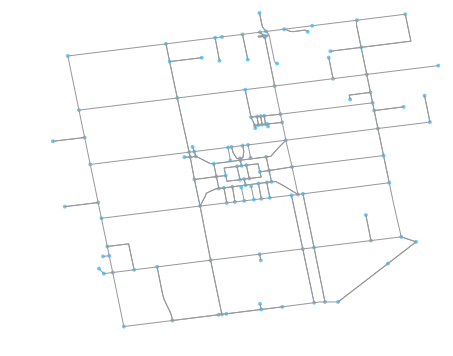

(<matplotlib.figure.Figure at 0x271e3a5ccf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x271e3a646d8>)

In [33]:
# Visualizing Street Network and cul-de-sacs in union square grid
union_square = ox.graph_from_point((37.787994,-122.407437), distance=300, network_type='all')
ox.plot_graph(union_square)

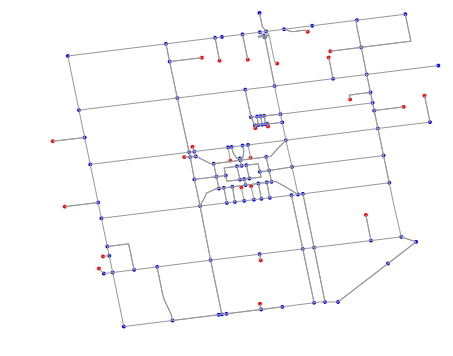

(<matplotlib.figure.Figure at 0x271e40a0f60>,
 <matplotlib.axes._subplots.AxesSubplot at 0x271e3dd50f0>)

In [34]:
# Red Nodes are endpoints of cul-de-sacs
culdesacs = [key for key, value in union_square.graph['streets_per_node'].items() if value==1]
nc = ['r' if node in culdesacs else 'b' for node in union_square.nodes()]
ox.plot_graph(union_square, node_color=nc)

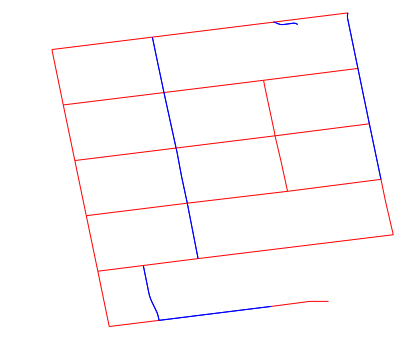

(<matplotlib.figure.Figure at 0x271e3a735c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x271e316d320>)

In [35]:
# Visualizing one way streets (network_type has to be drive)
# Red streets are one way streets
union_square_d = ox.graph_from_point((37.787994,-122.407437), distance=300, network_type='drive')
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in union_square_d.edges(keys=True, data=True)]
ox.plot_graph(union_square_d, node_size=0, edge_color=ec)

## Generation of training and test dataset
In the following the traning and test datasets will be build - Standardized, Normalized and cleaned for traning the models

In [36]:
# first initialise important variables

if not os.path.exists("../../data/interim/train_cleaned.csv"):
    train_data = pd.read_csv("../../data/raw/train.csv")
    cleaned_data = reposition_outliers(train_data)
    cleaned_data.to_csv("../../data/interim/train_cleaned.csv", index=False)
    
if not os.path.exists("../../data/interim/test_cleaned.csv"):
    test_data = pd.read_csv("../../data/raw/test.csv")
    cleaned_data = reposition_outliers(test_data)
    cleaned_data.to_csv("../../data/interim/test_cleaned.csv", index=False)
    
train_data = pd.read_csv("../../data/interim/train_cleaned.csv")
train_data['Dates'] = pd.to_datetime(train_data['Dates'])

test_data = pd.read_csv("../../data/interim/test_cleaned.csv")
test_data['Dates'] = pd.to_datetime(test_data['Dates'])

# bounding box
min_x = -122.53
max_x = -122.35
min_y = 37.65
max_y = 37.84
dif_x = max_x - min_x
dif_y = max_y - min_y

# grid resolution
x_sections = 30
y_sections = 30
num_subregions = x_sections * y_sections
sufficient_n_non_prosecution = 100
sufficient_n_distribution = 200
sufficient_n_streets = 48

crimes = train_data['Category'].unique()
street_crime_distribution_dict = get_street_crime_distribution_dict(train_data, crimes, sufficient_n_streets)

In [37]:
# a function which builds the dataset

# always calculate regional features first
def build_and_store_regional_features(train_data):
    print("Processing regional features")
    print("-----------------------------")
    
    if not os.path.exists("../../data/processed/train_subregions.csv"):
        subregions = create_subregion_series(train_data, min_x, min_y, dif_x, dif_y, x_sections, y_sections)
        subregions = pd.concat([subregions], axis=1)
        subregions.to_csv("../../data/processed/train_subregions.csv", index=False)
    print("Finished: subregions")
        
    if not os.path.exists("../../data/processed/regional_non_prosecution_rates.csv"):
        subregions = pd.read_csv("../../data/processed/train_subregions.csv")
        subregions = subregions["subregion"]
        non_prosecution_rate = get_non_prosecution_rate_frame(train_data, subregions, num_subregions,
                                                          sufficient_n_non_prosecution)
        non_prosecution_rate = pd.concat([non_prosecution_rate], axis=1)
        non_prosecution_rate.to_csv("../../data/processed/regional_non_prosecution_rates.csv", index=False)
    print("Finished: regional non prosecution rates")
        
    if not os.path.exists("../../data/processed/regional_crime_distribution.csv"):
        subregions = pd.read_csv("../../data/processed/train_subregions.csv")
        subregions = subregions["subregion"]
        crimes = train_data['Category'].unique()
        crime_distribution = get_crime_distribution_frame(train_data, subregions, crimes, num_subregions, 
                                                          sufficient_n_distribution)
        crime_distribution.to_csv("../../data/processed/regional_crime_distribution.csv", index=False)
    print("Finished: regional crime distributions")
    print("Finished: build_and_store_regional_features")
    print()
        
def build_and_store_crime_features(data, name):
    print("Processing crime features")
    print("-----------------------------")
    
    if not os.path.exists("../../data/processed/" + name + "_time_features.csv"):
        time_features = generate_time_features(data)
        time_features.to_csv("../../data/processed/" + name + "_time_features.csv", index=False)
    print("Finished: time features")
    
    if not os.path.exists("../../data/processed/" + name + "_subregions.csv"):
        subregions = create_subregion_series(data, min_x, min_y, dif_x, dif_y, x_sections, y_sections)
        subregions = pd.concat([subregions], axis=1)
        subregions.to_csv("../../data/processed/" + name + "_subregions.csv", index=False)
    print("Finished: subregions")

    if not os.path.exists("../../data/processed/" + name + "_police_destrict.csv"):
        police_destricts = create_police_destrict_frame(data)
        police_destricts.to_csv("../../data/processed/" + name + "_police_destrict.csv", index=False)
    print("Finished: police destricts")
        
    if not os.path.exists("../../data/processed/" + name + "_police_distance.csv"):
        police_distance = get_police_distance_series(data)
        police_distance = pd.concat([police_distance], axis=1)
        police_distance.to_csv("../../data/processed/" + name + "_police_distance.csv", index=False)
    print("Finished: police distances")
        
    if not os.path.exists("../../data/processed/" + name + "_street_types.csv"):
        street_type = generate_street_types(data['Address'])
        street_type.to_csv("../../data/processed/" + name + "_street_types.csv", index=False)
    print("Finished: street types")
        
    if not os.path.exists("../../data/processed/" + name + "_non_prosecution_rates.csv"):
        subregions = pd.read_csv("../../data/processed/" + name + "_subregions.csv")
        subregions = subregions["subregion"]
        regional_non_prosecution_rate = pd.read_csv("../../data/processed/regional_non_prosecution_rates.csv")
        regional_non_prosecution_rate = regional_non_prosecution_rate["non_prosecution_rate"]
        non_prosecution_rates = pd.Series([regional_non_prosecution_rate[r] for r in subregions], name='non_prosecution_rate')
        non_prosecution_rates = pd.concat([non_prosecution_rates], axis=1)
        non_prosecution_rates.to_csv("../../data/processed/" + name + "_non_prosecution_rates.csv", index=False)
    print("Finished: non prosecution rates")
        
    if not os.path.exists("../../data/processed/" + name + "_crime_distribution.csv"):
        subregions = pd.read_csv("../../data/processed/" + name + "_subregions.csv")
        subregions = subregions["subregion"]
        distribution_local = pd.read_csv("../../data/processed/regional_crime_distribution.csv")
        crime_distribution = pd.DataFrame()
        for c in crimes:
            category_series = pd.Series([distribution_local[c][r] for r in subregions], name=c)
            crime_distribution = pd.concat([crime_distribution, category_series], axis=1)
        crime_distribution.to_csv("../../data/processed/" + name + "_crime_distribution.csv", index=False)
    print("Finished: crime distributions")
    
    if not os.path.exists("../../data/processed/" + name + "_street_crime_distribution.csv"):
        streets = data["Address"]
        street_crime_distribution = pd.DataFrame()
        for c in crimes:
            category_series = pd.Series([get_street_crime_rate(s, c, street_crime_distribution_dict) for s in streets], name=("street_" + c))
            street_crime_distribution = pd.concat([street_crime_distribution, category_series], axis=1)
        street_crime_distribution.to_csv("../../data/processed/" + name + "_street_crime_distribution.csv", index=False)
    print("Finished: finished street crime distributions")

    # here only subregions with criminal activity is regarded
    if not os.path.exists("../../data/processed/" + name + "_architectural_features.csv"):
        subregions = pd.read_csv("../../data/processed/" + name + "_subregions.csv")
        subregions = subregions["subregion"]
        architectural_features = generate_subregion_architectural_features(subregions, x_sections, y_sections, from_point=False)
        architectural_features.to_csv("../../data/processed/" + name + "_architectural_features.csv", index=False)
    print("Finished: architectural features")
    print("Finished: build_and_store_crime_features")
    print()

In [38]:
build_and_store_regional_features(train_data)
build_and_store_crime_features(train_data, "train")
build_and_store_crime_features(test_data, "test")

Processing regional features
-----------------------------
Finished: subregions
Finished: regional non prosecution rates
Finished: regional crime distributions
Finished: build_and_store_regional_features

Processing crime features
-----------------------------
Finished: time features
Finished: subregions
Finished: police destricts
Finished: police distances
Finished: street types
Finished: non prosecution rates
Finished: crime distributions
Finished: finished street crime distributions
Finished: architectural features
Finished: build_and_store_crime_features

Processing crime features
-----------------------------
Finished: time features
Finished: subregions
Finished: police destricts
Finished: police distances
Finished: street types
Finished: non prosecution rates
Finished: crime distributions
Finished: finished street crime distributions
Finished: architectural features
Finished: build_and_store_crime_features



In [39]:
t = pd.read_csv("../../data/processed/train_street_crime_distribution.csv")
t.head()

,street_WARRANTS,street_OTHER OFFENSES,street_LARCENY/THEFT,street_VEHICLE THEFT,street_VANDALISM,street_NON-CRIMINAL,street_ROBBERY,street_ASSAULT,street_WEAPON LAWS,street_BURGLARY,...,street_EMBEZZLEMENT,street_SUICIDE,street_LOITERING,street_SEX OFFENSES NON FORCIBLE,street_EXTORTION,street_GAMBLING,street_BAD CHECKS,street_TREA,street_RECOVERED VEHICLE,street_PORNOGRAPHY/OBSCENE MAT
0,-2.985679,-1.784834,-1.391354,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,-3.130667,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-9.21024,-5.630537,-9.21024
1,-2.985679,-1.784834,-1.391354,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,-3.130667,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-9.21024,-5.630537,-9.21024
2,-2.985679,-1.784834,-1.391354,-2.729575,-2.924890,-2.141545,-3.615665,-2.343883,-4.621396,-3.130667,...,-6.622794,-7.454398,-6.573365,-8.688077,-8.139989,-8.701685,-7.678642,-9.21024,-5.630537,-9.21024
3,-3.925268,-2.477938,-0.597837,-3.401197,-3.212187,-2.786382,-4.337291,-2.910991,-9.210240,-1.968216,...,-9.210240,-9.210240,-9.210240,-9.210240,-9.210240,-9.210240,-9.210240,-9.21024,-9.210240,-9.21024
4,-9.210240,-2.240710,-1.563976,-2.240710,-2.240710,-2.240710,-3.218876,-3.218876,-3.931826,-1.435085,...,-9.210240,-9.210240,-9.210240,-9.210240,-9.210240,-9.210240,-3.931826,-9.21024,-9.210240,-9.21024


### Build final dataset for training and testing from partial datasets

In [40]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


#global available label encoder to retrieve category description later on
le = preprocessing.LabelEncoder()

def concat_generated_subdataset(data, name):
    # loading distinct datasets
    base_path = "../../data/processed/"
    subregions = pd.read_csv(base_path + name + "_subregions.csv")
    non_presecution_rate = pd.read_csv(base_path + name + "_non_prosecution_rates.csv")
    crime_distribution = pd.read_csv(base_path + name + "_crime_distribution.csv")
    time_features = pd.read_csv(base_path + name + "_time_features.csv")
    police_districts = pd.read_csv(base_path + name + "_police_destrict.csv")
    police_distance = pd.read_csv(base_path + name + "_police_distance.csv")
    street_types = pd.read_csv(base_path + name + "_street_types.csv")
    street_crime_distribution = pd.read_csv(base_path + name + "_street_crime_distribution.csv")
    architectural_feat = pd.read_csv(base_path + name + "_architectural_features.csv" )
    
    #print("subregions: ", len(subregions))
    #print("non_pres: ", len(non_presecution_rate))
    #print("crim_dis: ", len(crime_distribution))
    #print("time feat: ", len(time_features))
    #print("police districts: ", len(police_districts))
    #print("police dist: ", len(police_distance))
    #print("street types: ", len(street_types))
    #print("architect: ", len(architectural_feat))
     
    series = [
        data['X'],
        data['Y'],
        subregions,
        time_features,
        police_districts,
        crime_distribution,
        street_crime_distribution,
        non_presecution_rate,
        police_distance, street_types,
        architectural_feat
    ]
    
    if name == 'train':
        # label encoding category
        categories = pd.Series(le.fit_transform(data['Category']), name='Category')
        series = [categories] + series
    
    
    return pd.concat(series, axis=1)
    

In [41]:
def build_final_datasets(pca_components=10):
    """
    Builds the final datasets for processing with the neuronal network
    Performs PCA and standard scaling on these datasets
    
    This is done this way instead of a pipline due to a separatly
    provided testset by kaggle
    """
    
    pca = PCA(n_components=pca_components)
    ss = StandardScaler()
    
    train_data = pd.read_csv("../../data/interim/train_cleaned.csv")
    train_data['Dates'] = pd.to_datetime(train_data['Dates'])
    train = concat_generated_subdataset(train_data, 'train')

    test_data = pd.read_csv("../../data/interim/test_cleaned.csv")
    test_data['Dates'] = pd.to_datetime(test_data['Dates'])
    test = concat_generated_subdataset(test_data, 'test')
    
    
    missing_columns = set(train.columns) - set(test.columns)
    missing_columns.remove('Category')
    
    print("Missing columns in test set: ", set(train.columns) - set(test.columns))
    
    print("Imputing empty {} (0) columns into test set".format(missing_columns))
    
    test['BUFANO'] = 0
    test['FERLINGHETTI'] = 0
      
    print("Extracting values and ravel categories")
    
    X = train.iloc[:,1:].values
    y = train.iloc[:,:1].values.ravel()
    test = test.iloc[:].values
    
    print("Standard Scaling train and test set")
    
    X = ss.fit_transform(X)
    test = ss.transform(test)
    
    print("Applying PCA on training and test set")
    
    # X = pca.fit_transform(X)
    # test = pca.transform(test)
  
    print("\n----Done----")
    
    return X, y, test

In [42]:
X,y,test = build_final_datasets()

Missing columns in test set:  {'FERLINGHETTI', 'BUFANO', 'Category'}
Imputing empty {'FERLINGHETTI', 'BUFANO'} (0) columns into test set
Extracting values and ravel categories
Standard Scaling train and test set
Applying PCA on training and test set

----Done----


## Defining Multilayer perceptron

In [43]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 180, 200),
                    activation='tanh',
                    learning_rate_init=0.005,
                    max_iter=400)

## Training MLP for local test
Always execute all the rows here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
mlp.fit(X_train, y_train)

In [ ]:
mlp_proba = mlp.predict_proba(X_test)
mlp_pred = mlp.predict(X_test)
log_score = log_loss(y_test, mlp_proba)
acc_score = accuracy_score(y_test, mlp_pred)
print("log_loss: ", log_score)
print("Accuracy: ", acc_score)

## Training MLP for submission

In [44]:
mlp.fit(X, y)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 180, 200), learning_rate='constant',
       learning_rate_init=0.005, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [45]:
def create_submission(probabilities):
    """
    Creates a kaggle csv submission file within the notebook folder
    """
    submission = pd.DataFrame(probabilities, columns=list(le.classes_))
    submission.insert(0, 'Id', range(0, len(submission)))
    submission.to_csv("submission.csv", index=False)

Training MLP with sknn and grid search

In [46]:
def create_submission(probabilities):
    submission = pd.DataFrame(probabilities, columns=list(le.classes_))
    submission.insert(0, 'Id', range(0, len(submission)))
    submission.to_csv("submission.csv", index=False)

In [ ]:
create_submission(mlp.predict_proba(test))